In [10]:
%%capture 

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

# Training a machine learning model with automatic differentiation

In this tutorial we will: 

* implement a toy version of a typical machine learning setup,
* understand how automatic differentiation allows us to compute gradients of the machine learning model, and
* use automatic differentiation to train the model.

First some imports...

In [11]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

Importing numpy via pennylane wraps numpy in an "automatic differentiation" framework. We can now automatically compute the gradient of most numpy functions.

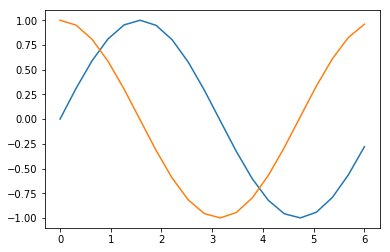

In [12]:
x_axis = np.linspace(0, 6, 20)
s = np.sin(x_axis)

gradient_fn = qml.grad(np.sin, argnum=0)

g = [gradient_fn(x) for x in x_axis]

plt.plot(x_axis, s)
plt.plot(x_axis, g)

## 1. The three basic ingredients

A machine learning problem usually consists of *data*, a *model (family)* and a *cost function*: 

<br />
<img src="figures/data-model-cost.png" width="500">
<br />

*Training* selects the best model from the family by minimising the cost on a training set of data samples. If we design the optimisation problem well, the trained model will also have a low cost on new sets of data samples that have not been used in training. This means that the model *generalises* well. 

We will now create examples for each ingredient.

### Data

Let us create a two-dimensional toy dataset.

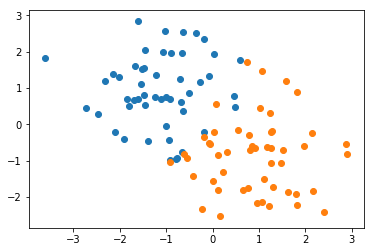

In [13]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 

plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

In [14]:
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))

In [15]:
data[0]

(tensor([-0.50328585,  0.8617357 ], requires_grad=True),
 tensor(-1., requires_grad=True))

### Model family

Next, we construct a linear model.

In [16]:
def model(x, w):
    return np.dot(x, w)

Let's try it out.

In [17]:
w = np.array([-0.2, -0.2])

model(X0[0], w)

-0.07168997036800963

We can plot the decision boundary, or the boundary in data space where the model flips from a negative to a positive prediction

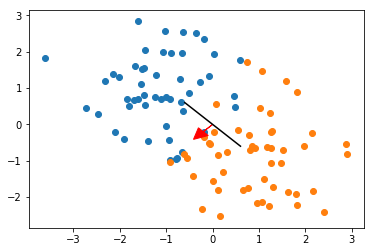

In [18]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

### Cost function

How good is the model on a single input-output training pair?

In [19]:
def loss(a, b):
    return (a - b)**2

In [20]:
loss(-1, -1)

0

What is the average loss on a data set of multiple pairs?

In [21]:
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w)
        c += loss(prediction, y)
    return c/len(data)

In [22]:
w = np.array([0.1, -0.1])
average_loss(w, data)

0.6705617111275896

## 2. Automatic computation of  gradients

Because we imported PennyLane's numpy version, we can now compute gradients of the average loss with respect to the weights!

In [23]:
gradient_fn = qml.grad(average_loss, argnum=0)
gradient_fn(w, data)

array([-1.50619253,  1.25442995])

We can use gradients to guess better candidates for parameters.

In [24]:
w_new = w - 0.05*gradient_fn(w, data)

In [25]:
average_loss(w_new, data)

0.5039476500948409

This works because the gradient always points towards the steepest ascent in the cost landscape.

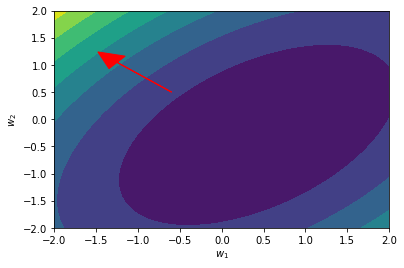

In [26]:
# compute the gradient at some point in parameter space
some_w = np.array([-0.6, 0.5])
g = 0.01*gradient_fn(some_w, data)

# make a contourplot of the cost
w1s = np.linspace(-2, 2)
w2s = np.linspace(-2, 2)
cost_grid = []
for w1 in w1s:
    for w2 in w2s:
        w = np.array([w1, w2])
        cost_grid.append(average_loss(w, data))
cost_grid = np.array(cost_grid).reshape((50, 50))
plt.contourf(w1s, w2s, cost_grid.T)

plt.arrow(some_w[0], some_w[1], some_w[0] + g[0], some_w[1] + g[1], 
          head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

## 3. Training with gradient descent

Putting it all together, we can train the linear model.

In [27]:
w_init = np.random.random(size=(2,))
w = np.array(w_init)

history = []
for i in range(15):
    w_new = w - 0.05*gradient_fn(w, data)
    print(average_loss(w_new, data))
    history.append(w_new)
    w = w_new

1.3500100407100541
1.1021852209348377
0.9290184060813584
0.8027576735134763
0.7073372523673335
0.6331673539752455
0.5743007976098509
0.5268826928791955
0.488294380852497
0.45667438524266574
0.4306452071742513
0.4091534224361
0.3913728909446769
0.3766437270037941
0.3644320177904416


We can easily visualise the path that gradient descent took in parameter space.

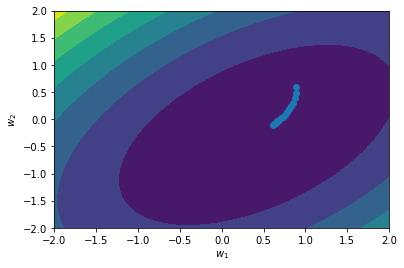

In [28]:
plt.contourf(w1s, w2s, cost_grid.T)
history = np.array(history)
plt.plot(history[:, 0], history[:, 1], "-o")
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

Training didn't fully converge yet, but the decision boundary is already better.

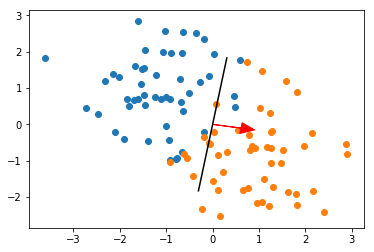

In [29]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

# TASKS 



1. Add a constant scalar bias term $b \in \mathbb{R}$ to the model,

    $$ f(x, w) = \langle w, x \rangle + b, $$

   and train both $w$ and $b$ at the same time.
   
   One solution would be:
  

In [30]:
def model_with_bias(x, w, b):
    return np.dot(x, w) + b

def average_loss(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn_w = qml.grad(average_loss, argnum=0)
gradient_fn_b = qml.grad(average_loss, argnum=1)

w_init = np.random.random(size=(2,))
w = np.array(w_init)
b = np.array(0.0) # start with zero bias

for i in range(15):
    w_new = w - 0.05*gradient_fn_w(w, b, data)
    b_new = b - 0.05*gradient_fn_b(w, b, data)
    print(average_loss(w_new, b_new, data))
    w = w_new
    b = b_new

1.2616449656336537
0.988912134009297
0.8129177682298492
0.6939556956733344
0.6098313628714149
0.5479010828832798
0.5007737422401507
0.46398222291446933
0.4347155425348416
0.41112333949272645
0.3919301146116048
0.3762178754665706
0.3633009553605108
0.3526517881946461
0.343855259986162


2. Change the model to a neural network with a single hidden layer.

    $$ f(x, w, W) = \langle w, \varphi(Wx) \rangle,$$

   where $W$ is a weight matrix of suitable dimension and $\varphi$ a hand-coded nonlinar activation function. 
   
   Tipp: You can use the vector-valued sigmoid function 
   
   ```
   def sigmoid(z):
        return 1/(1 + np.exp(-x))
   ```
   

This can be done similar to Task 1:

In [31]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def model_nn(x, W, w):
    return np.dot(w, sigmoid(W @ x)) 

def average_loss(W, w, data):
    c = 0
    for x, y in data:
        prediction = model_nn(x, W, w)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn_W = qml.grad(average_loss, argnum=0)
gradient_fn_w = qml.grad(average_loss, argnum=1)

w_init = np.random.random(size=(2,))
W_init = np.random.random(size=(2, 2))

w = np.array(w_init)
W = np.array(W_init)

for i in range(15):
    W_new = W - 0.05*gradient_fn_W(W, w, data)
    w_new = w - 0.05*gradient_fn_w(W, w, data)
    print(average_loss(W_new, w_new, data))
    w = w_new
    W = W_new

1.0864971217131514
1.0738404487457542
1.062841149998976
1.0532747498348558
1.0449475635041503
1.0376923428455198
1.031364566158544
1.0258392703946235
1.0210083413790096
1.0167781920007801
1.0130677698869484
1.0098068455539089
1.0069345398252034
1.004398055748033
1.0021515855905072


3. Code up the above example using PyTorch.

In [32]:
#!pip install torch 

In [33]:
import torch

data = [[torch.tensor(x), torch.tensor(y)] for x, y in data]

def loss(a, b):
    return (a - b)**2

def sigmoid(z):
    return 1/(1 + torch.exp(-z))

def model_torch(x, w):
    return torch.dot(x,w) 

def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model_torch(x, w)
        c += loss(prediction, y)
    return c/len(data)

w_init = np.random.random(size=(2,))

w = torch.tensor(w_init, requires_grad=True)

opt = torch.optim.Adam([w], lr = 0.1)

# One way of optimising is to use closures
def closure():
    opt.zero_grad()
    loss = average_loss(w, data)
    loss.backward()
    return loss

for i in range(15):
    opt.step(closure)
    
    print(average_loss(w, data))

tensor(0.9849, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7700, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.6496, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5869, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5432, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5015, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4589, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4173, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3794, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3481, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3260, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3150, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3152, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3248, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3403, dtype=torch.float64, grad_fn=<DivBackward0>)
